<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/test_YOLO_v3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/data

In [ ]:
### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드하여 /content/pretrained 디렉토리 아래에 저장. 
!mkdir ./pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true 

!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

!ls /content/pretrained

In [3]:
import os
import cv2

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'
#config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [4]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [11]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, is_print=True):
    
    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    # opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
    # 따라서 아래 코드는 강의 영상의 layers_names[i[0] - 1]에서 layers_names[i - 1] 로 변경합니다. 2022.08.09
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold and class_id == 2: ## 함수의 파라미터로 클래스ID 받기!!
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    
    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

In [5]:
def crop_detected_img(cv_net, img_array, conf_threshold, nms_threshold, is_print=True):
    object_place = []

    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    # opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
    # 따라서 아래 코드는 강의 영상의 layers_names[i[0] - 1]에서 layers_names[i - 1] 로 변경합니다. 2022.08.09
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold and class_id == 2: ## 함수의 파라미터로 클래스ID 받기!!
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    
    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])

            object_place = [int(left), int(top), int(left+width), int(top+height)]

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return object_place

In [6]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

# image 로드 
img = cv2.imread('/content/data/jojo_comics.jpg')

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'

# darknet yolo pretrained 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
crop_place_img = crop_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

print(crop_place_img)

In [8]:
# image 로드 
source = cv2.imread('/content/data/marcerati.jpg')

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'

# darknet yolo pretrained 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_source = get_detected_img(cv_net_yolo, source, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

source_rgb = cv2.cvtColor(draw_source, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(source_rgb)

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
crop_place_source = crop_detected_img(cv_net_yolo, source, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

print(crop_place_source)

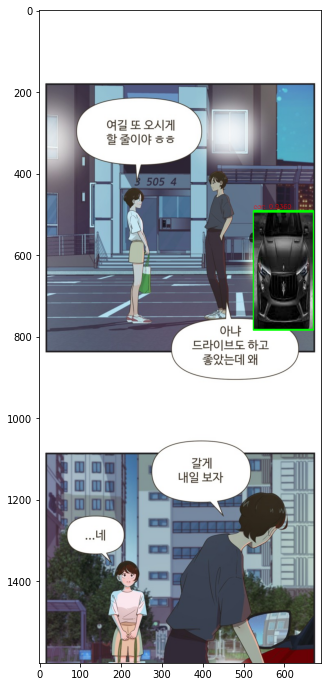

In [16]:
roi = draw_img[crop_place_img[1]:crop_place_img[3], crop_place_img[0]:crop_place_img[2]]
w, h, c = roi.shape

roi_source = draw_source[crop_place_source[1]:crop_place_source[3], crop_place_source[0]:crop_place_source[2]]
w2, h2, c2 = roi_source.shape

roi_source_resize = cv2.resize(roi_source, (int(h), int(w)), None, 0, 0, cv2.INTER_AREA)

draw_img[crop_place_img[1]:crop_place_img[3], crop_place_img[0]:crop_place_img[2]] = roi_source_resize
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)